In [ ]:
import os
import Augmentor

# Define the base directory where the subfolders are located
base_directory = r"E:\Research\\components"

# Loop through all 15 folders
for i in range(1, 5):
    # Define the path for the current folder using os.path.join
    folder_name = str(i)
    folder_path = os.path.join(base_directory, folder_name)
    
    # Check if the folder exists
    if os.path.exists(folder_path):
        # Create an Augmentor pipeline for image augmentation
        p = Augmentor.Pipeline(folder_path)
        
        # Add augmentation operations as needed
        p.zoom(probability=0.6, min_factor=0.75, max_factor=1)
        p.flip_top_bottom(probability=0.5)
        p.flip_left_right(probability=0.5)
        p.rotate(probability=1, max_left_rotation=25, max_right_rotation=25)
        p.rotate_random_90(probability=1)
        p.random_brightness(probability=0.5, min_factor=0.4, max_factor=0.9)
        p.random_distortion(probability=0.5, grid_width=7, grid_height=8, magnitude=9)
        p.random_erasing(probability=0.3, rectangle_area=0.2)
        
        # Sample the augmented images (generate 150 augmented images for each folder)
        p.sample(150)
    else:
        print(f"Folder {folder_name} does not exist at {folder_path}")

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define the root directory containing subfolders for each image class
data_dir = 'E:\Research\data'
batch_size = 32
image_size = (224, 224)  # Adjust the size as needed

# Use the ImageDataGenerator to load and preprocess images
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    validation_split=0.2,  # Split the data into training and validation sets
)

# Create a training dataset
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    subset='training',  # Specify 'training' to create the training dataset
    shuffle=True,  # Shuffle the data
)

# Create a validation dataset
val_data = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    subset='validation',  # Specify 'validation' to create the validation dataset
    shuffle=False,  # Do not shuffle the validation data
)

# Optionally, you can create a test dataset in a similar way
# test_data = datagen.flow_from_directory(
#     'test_data_dir',
#     target_size=image_size,
#     batch_size=batch_size,
#     class_mode='categorical',  # Use 'categorical' for multi-class classification
#     shuffle=False,  # Do not shuffle the test data
# )

# You can now use train_data and val_data for training and validation in your machine learning model.

In [1]:
import numpy as np
import cv2 as cv
from glob import glob
from tqdm import tqdm

# Initialize data and label lists
data_list = []
label_list = []

# Define the shape for resizing
image_shape = (32, 32)

# Function to convert an image to an array
def img_to_arr(add, shape):
    image = cv.imread(add)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.resize(image, shape)
    image = image.astype("float32") / 255
    return image

for i in range(1, 16):
    print('Extracting patches for Component ' + str(i))
    path = 'E:\\Research\\data\\train\\' + str(i) + '\\'
    type_1 = glob(path + '*.bmp')

    for image_path in tqdm(type_1):
        image = img_to_arr(image_path, image_shape)
        data_list.append(image)
        label_list.append(i)

data = np.stack(data_list, axis=0)  # Convert the list of images to a NumPy array
labels = np.array(label_list)

# Save the data and labels
np.save('E:\\Research\\test\\data_32.npy', data)
np.save('E:\\Research\\test\\labels.npy', labels)


Extracting patches for Component 1


100%|██████████| 5036/5036 [03:15<00:00, 25.69it/s]


Extracting patches for Component 2


100%|██████████| 5000/5000 [01:34<00:00, 53.02it/s]


Extracting patches for Component 3


100%|██████████| 5250/5250 [01:41<00:00, 51.60it/s]


Extracting patches for Component 4


100%|██████████| 5244/5244 [03:20<00:00, 26.12it/s]


Extracting patches for Component 5


100%|██████████| 4250/4250 [19:55<00:00,  3.55it/s]  


Extracting patches for Component 6


100%|██████████| 4000/4000 [01:32<00:00, 43.07it/s]


Extracting patches for Component 7


100%|██████████| 1250/1250 [00:26<00:00, 48.04it/s]


Extracting patches for Component 8


100%|██████████| 4250/4250 [01:12<00:00, 58.51it/s]


Extracting patches for Component 9


100%|██████████| 5588/5588 [03:05<00:00, 30.10it/s]


Extracting patches for Component 10


100%|██████████| 5388/5388 [02:04<00:00, 43.15it/s]


Extracting patches for Component 11


100%|██████████| 6250/6250 [01:33<00:00, 67.12it/s]


Extracting patches for Component 12


100%|██████████| 250/250 [00:05<00:00, 45.98it/s]


Extracting patches for Component 13


100%|██████████| 5713/5713 [02:20<00:00, 40.75it/s]


Extracting patches for Component 14


100%|██████████| 4566/4566 [02:43<00:00, 27.94it/s]


Extracting patches for Component 15


100%|██████████| 3500/3500 [01:47<00:00, 32.63it/s]


In [2]:
import numpy as np
import cv2 as cv
from glob import glob
from tqdm import tqdm

data = np.empty((32, 32))  
label = []

def img_to_arr(add, shape):
    image = cv.imread(add)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.resize(image, shape)
    image = image.astype("float32") / 255
    return np.array(image)

for i in range(1, 5):
    print('Extracting patches for Component' + str(i))
    path = 'E:\Research\components' + str(i) + '/'
    type_1 = glob(path + '*.bmp')

    for j in tqdm(range(len(type_1))):
        image = img_to_arr(type_1[j], [32, 32])
        data = np.dstack([data, image])
        label.append(i)

Extracting patches for Component1


0it [00:00, ?it/s]


Extracting patches for Component2


0it [00:00, ?it/s]


Extracting patches for Component3


0it [00:00, ?it/s]


Extracting patches for Component4


0it [00:00, ?it/s]


In [3]:

def img_to_arr(add, shape):
  image = cv.imread(add)
  image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  image = cv.resize(image,shape)
  image=image.astype("float32") / 255
  #image = image/255.0
  #image = image.reshape((1,shape[0]*shape[1]))
  return (np.array(image))

for i in range(1,16):
  print('Extracting patches for '+str(i))
  path='E:\Research\\test'+ str(i)+'/'
  type_1 = glob(path+'*.bmp')
  for j in tqdm(range(len(type_1))):
    image=img_to_arr(type_1[j],[32,32])
    data=np.dstack([data,image])
    label.append(i)

Extracting patches for 1


0it [00:00, ?it/s]


Extracting patches for 2


0it [00:00, ?it/s]


Extracting patches for 3


0it [00:00, ?it/s]


Extracting patches for 4


0it [00:00, ?it/s]


Extracting patches for 5


0it [00:00, ?it/s]


Extracting patches for 6


0it [00:00, ?it/s]


Extracting patches for 7


0it [00:00, ?it/s]


Extracting patches for 8


0it [00:00, ?it/s]


Extracting patches for 9


0it [00:00, ?it/s]


Extracting patches for 10


0it [00:00, ?it/s]


Extracting patches for 11


0it [00:00, ?it/s]


Extracting patches for 12


0it [00:00, ?it/s]


Extracting patches for 13


0it [00:00, ?it/s]


Extracting patches for 14


0it [00:00, ?it/s]


Extracting patches for 15


0it [00:00, ?it/s]


In [2]:
import numpy as np

data_1 = None  # Initialize as None
label1 = []

for i in range(1, 16):
    print('Combining features for ' + str(i))
    
    if i == 14:
        data2 = np.load('E:\\Research\\test\\data_32_' + str(i) + '.npy')
        label2 = np.load('E:\\Research\\test\\labels_32_' + str(i) + '.npy')
        
        if data_1 is None:
            data_1 = data2
        else:
            if data_1.shape[2] == data2.shape[2]:
                data_1 = np.dstack([data_1, data2])
            else:
                print(f"Dimensions don't match for Component {i}. Skipping.")
        
        for j in label2:
            label1.append(j)

# Ensure data_1 has 3 dimensions (height, width, num_samples)
if data_1 is not None and data_1.ndim == 2:
    data_1 = data_1[:, :, np.newaxis]

# Save the combined data and labels
if data_1 is not None:
    np.save('E:\\Research\\test\\fulldata_32.npy', data_1)
if label1:
    np.save('E:\\Research\\test\\fulllabels_32.npy', label1)


Combining features for 1
Combining features for 2
Combining features for 3
Combining features for 4
Combining features for 5
Combining features for 6
Combining features for 7
Combining features for 8
Combining features for 9
Combining features for 10
Combining features for 11
Combining features for 12
Combining features for 13
Combining features for 14


Combining features for 15


In [3]:
import numpy as np
import cv2 as cv
from glob import glob
from tqdm import tqdm

# Initialize data and label lists
data_list = []
label_list = []

# Define the shape for resizing
image_shape = (32, 32)

# Function to convert an image to an array
def img_to_arr(add, shape):
    image = cv.imread(add)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.resize(image, shape)
    image = image.astype("float32") / 255
    return image

for i in range(1, 16):
    print('Extracting patches for Component ' + str(i))
    path = 'E:\\Research\\data\\train\\' + str(i) + '\\'
    type_1 = glob(path + '*.bmp')

    for image_path in tqdm(type_1):
        image = img_to_arr(image_path, image_shape)
        data_list.append(image)
        label_list.append(i)

data = np.stack(data_list, axis=0)  # Convert the list of images to a NumPy array
labels = np.array(label_list)

# Print labels to check if they are correctly populated
print(labels)

# Save the data and labels
np.save('E:\\Research\\test\\data_32_14.npy', data)
np.save('E:\\Research\\test\\labels_32_14.npy', labels)

import numpy as np

data_1 = None  # Initialize as None
label1 = []

for i in range(1, 16):
    print('Combining features for ' + str(i))
    
    if i == 14:
        data2 = np.load('E:\\Research\\test\\data_32_' + str(i) + '.npy')
        label2 = np.load('E:\\Research\\test\\labels_32_' + str(i) + '.npy')
        
        if data_1 is None:
            data_1 = data2
        else:
            if data_1.shape[2] == data2.shape[2]:
                data_1 = np.dstack([data_1, data2])
            else:
                print(f"Dimensions don't match for Component {i}. Skipping.")
        
        for j in label2:
            label1.append(j)

# Ensure data_1 has 3 dimensions (height, width, num_samples)
if data_1 is not None and data_1.ndim == 2:
    data_1 = data_1[:, :, np.newaxis]

# Print label1 to check if it's correctly populated
print(label1)

# Save the combined data and labels
if data_1 is not None:
    np.save('E:\\Research\\test\\fulldata_32.npy', data_1)
if label1:
    np.save('E:\\Research\\test\\fulllabels_32.npy', label1)


Extracting patches for Component 1


 69%|██████▉   | 3476/5036 [02:38<01:10, 21.97it/s]


KeyboardInterrupt: 

In [4]:

import numpy as np

data_1 = None  # Initialize as None
label1 = []

for i in range(1, 16):
    print('Combining features for ' + str(i))
    
    if i == 14:
        data2 = np.load('E:\\Research\\test\\data_32_' + str(i) + '.npy')
        label2 = np.load('E:\\Research\\test\\labels_32_' + str(i) + '.npy')
        
        if data_1 is None:
            data_1 = data2
        else:
            if data_1.shape[2] == data2.shape[2]:
                data_1 = np.dstack([data_1, data2])
            else:
                print(f"Dimensions don't match for Component {i}. Skipping.")
        
        for j in label2:
            label1.append(j)

# Ensure data_1 has 3 dimensions (height, width, num_samples)
if data_1 is not None and data_1.ndim == 2:
    data_1 = data_1[:, :, np.newaxis]

# Print label1 to check if it's correctly populated
print(label1)

# Save the combined data and labels
if data_1 is not None:
    np.save('E:\\Research\\test\\fulldata_32.npy', data_1)
if label1:
    np.save('E:\\Research\\test\\fulllabels_32.npy', label1)


Combining features for 1
Combining features for 2
Combining features for 3
Combining features for 4
Combining features for 5
Combining features for 6
Combining features for 7
Combining features for 8
Combining features for 9
Combining features for 10
Combining features for 11
Combining features for 12
Combining features for 13
Combining features for 14
Combining features for 15
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [13]:
from sklearn.model_selection import train_test_split
import numpy as np

# Load data and labels
data_1 = np.load('E:\\Research\\test\\data_32_14.npy')
label = np.load('E:\\Research\\test\\labels_32_14.npy')

# Reshape the data (assuming the shape is (num_samples, height, width))
data_1 = data_1.reshape(data_1.shape[0], 32, 32, 1)

label = label - 1

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(data_1, label, test_size=0.4, random_state=10, stratify=label)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10, stratify=y_temp)


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define your model suitable for 32x32 input images
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(15, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with your data
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# After training, use the model to predict
y_pred = model.predict(X_test)


Epoch 1/10
1229/1229 [==============================] - 123s 97ms/step - loss: 1.8871 - accuracy: 0.3838 - val_loss: 1.5375 - val_accuracy: 0.4974
Epoch 2/10
1229/1229 [==============================] - 63s 51ms/step - loss: 1.3382 - accuracy: 0.5576 - val_loss: 1.3507 - val_accuracy: 0.5520
Epoch 3/10
1229/1229 [==============================] - 56s 46ms/step - loss: 1.0786 - accuracy: 0.6410 - val_loss: 1.2884 - val_accuracy: 0.5801
Epoch 4/10
1229/1229 [==============================] - 76s 62ms/step - loss: 0.8754 - accuracy: 0.7088 - val_loss: 1.2975 - val_accuracy: 0.5870
Epoch 5/10
1229/1229 [==============================] - 116s 94ms/step - loss: 0.6962 - accuracy: 0.7685 - val_loss: 1.3822 - val_accuracy: 0.5856
Epoch 6/10
1229/1229 [==============================] - 107s 87ms/step - loss: 0.5491 - accuracy: 0.8172 - val_loss: 1.4668 - val_accuracy: 0.5870
Epoch 7/10
1229/1229 [==============================] - 111s 90ms/step - loss: 0.4139 - accuracy: 0.8642 - val_loss: 1.57

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.image import resize
import tensorflow as tf

# Resize your test images to 256x256
X_test_resized = resize(X_test, (256, 256), method='bilinear')
model.compile(optimizer='Adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
#model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
#history = model.fit(X_train, y_train, epochs=20, batch_size=256, validation_split=.2)
history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_val,y_val))
# Assuming you have predictions in y_pred (replace with your actual predictions)
y_pred = model.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "d:\anaconda\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "d:\anaconda\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "d:\anaconda\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "d:\anaconda\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "d:\anaconda\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "d:\anaconda\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "d:\anaconda\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "d:\anaconda\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "d:\anaconda\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "d:\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "d:\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "d:\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "d:\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "d:\anaconda\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "d:\anaconda\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "d:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "d:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "d:\anaconda\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "d:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "d:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "d:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\harsh\AppData\Local\Temp\ipykernel_12280\3679883463.py", line 13, in <module>
      history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_val,y_val))
    File "d:\anaconda\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda\lib\site-packages\keras\src\engine\training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "d:\anaconda\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "d:\anaconda\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\anaconda\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "d:\anaconda\lib\site-packages\keras\src\engine\training.py", line 1081, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "d:\anaconda\lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
      return self.compiled_loss(
    File "d:\anaconda\lib\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "d:\anaconda\lib\site-packages\keras\src\losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "d:\anaconda\lib\site-packages\keras\src\losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "d:\anaconda\lib\site-packages\keras\src\losses.py", line 2354, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "d:\anaconda\lib\site-packages\keras\src\backend.py", line 5762, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Received a label value of 14 which is outside the valid range of [0, 10).  Label values: 3 0 10 10 7 9 7 1 6 13 1 2 9 9 9 12 11 8 3 13 0 5 10 14 5 2 12 10 4 9 9 13 4 10 9 1 3 8 0 9 8 2 1 2 14 4 3 10 4 3 10 9 5 10 2 2 10 8 10 12 7 12 1 14 7 12 2 3 4 0 8 14 12 8 12 2 5 8 3 12 10 0 0 14 10 12 9 5 8 3 8 8 13 3 8 3 10 7 13 14 0 3 13 2 4 3 13 1 0 3 14 2 4 10 0 5 12 4 12 0 7 4 3 14 0 10 13 13 0 1 12 10 13 8 8 0 13 7 4 14 4 14 7 4 9 7 3 12 11 0 1 14 13 3 8 0 0 0 4 8 3 7 5 2 10 9 10 3 7 7 13 3 13 0 5 4 0 7 9 12 7 9 9 11 1 12 1 1 10 0 4 10 3 1 13 7 13 13 2 10 12 5 5 8 0 9 6 3 8 10 5 8 9 8 1 7 2 0 0 10 1 5 14 10 5 1 0 1 1 3 2 7 8 2 1 9 1 9 14 7 10 12 4 1 1 10 7 0 0 1 1 3 10 0 0 4
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_8920]

Epoch 1/10


d:\anaconda\lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


154/154 [==============================] - 105s 601ms/step - loss: 1.8303 - accuracy: 0.4214 - val_loss: 1.6551 - val_accuracy: 0.4565
Epoch 2/10
154/154 [==============================] - 76s 494ms/step - loss: 1.5039 - accuracy: 0.5005 - val_loss: 1.4840 - val_accuracy: 0.5113
Epoch 3/10
154/154 [==============================] - 73s 471ms/step - loss: 1.3059 - accuracy: 0.5613 - val_loss: 1.3826 - val_accuracy: 0.5326
Epoch 4/10
154/154 [==============================] - 22s 138ms/step - loss: 1.1636 - accuracy: 0.6073 - val_loss: 1.3308 - val_accuracy: 0.5470
Epoch 5/10
154/154 [==============================] - 17s 108ms/step - loss: 1.0562 - accuracy: 0.6432 - val_loss: 1.3320 - val_accuracy: 0.5521
Epoch 6/10
154/154 [==============================] - 16s 104ms/step - loss: 0.9592 - accuracy: 0.6755 - val_loss: 1.3562 - val_accuracy: 0.5509
Epoch 7/10
410/410 [==============================] - 3s 6ms/step


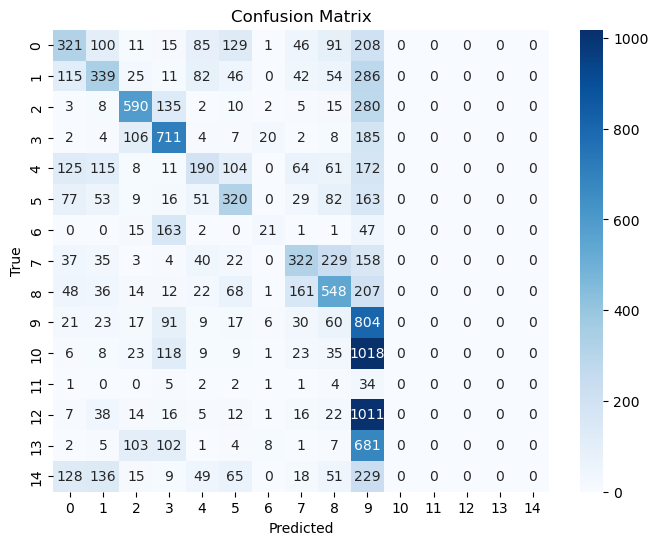

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# Clip the labels to the range [0, 9]
y_train_clipped = np.clip(y_train, 0, 9)
y_val_clipped = np.clip(y_val, 0, 9)

from tensorflow.keras.layers import Conv2D, Flatten

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    # Add more layers as needed
    Flatten(),
    Dense(64, activation='relu'),
    Dense(20, activation='softmax')
])


# Compile the model
model.compile(optimizer='Adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Fit the model with clipped labels
history = model.fit(X_train, y_train_clipped, epochs=10, batch_size=256,
                    validation_data=(X_val, y_val_clipped), callbacks=[early_stop])

# Get predictions on test data
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


410/410 [==============================] - 7s 16ms/step


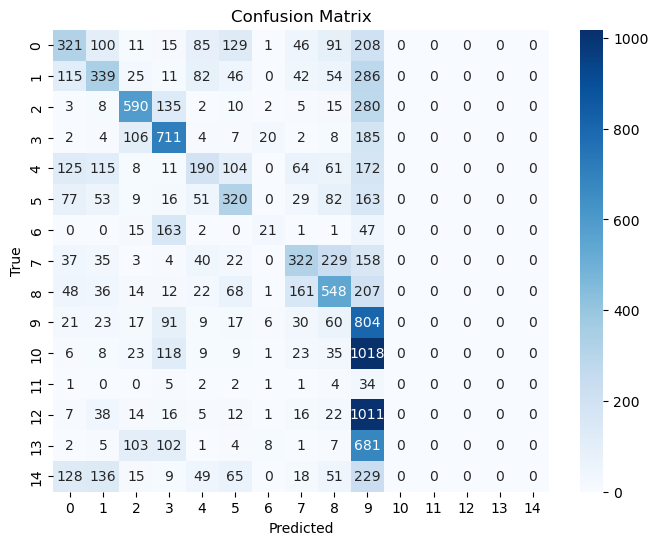

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have predictions in y_pred (replace with your actual predictions)
y_pred = model.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [12]:
import numpy as np
import os

# Load data and labels
data_1 = np.load('E:\\Research\\test\\data_32_14.npy')
label = np.load('E:\\Research\\test\\labels_32_14.npy')

# Define your criteria for identifying faulty images
def is_faulty_image(image):
    # Implement your criteria here
    # For example, you can check if the image content is faulty
    # or based on other properties of the image.

    # Here's an example that assumes faulty images have very low mean intensity:
    return np.mean(image) < 0.1  # Adjust the threshold as needed

# Create a folder to store non-faulty images
output_folder = 'E:\\Research\\test\\non_faulty_images'
os.makedirs(output_folder, exist_ok=True)

# Iterate through the images and labels, and keep non-faulty images
non_faulty_data = []
non_faulty_labels = []

for image, label_value in zip(data_1, label):
    if not is_faulty_image(image):
        non_faulty_data.append(image)
        non_faulty_labels.append(label_value)

# Convert lists to NumPy arrays
non_faulty_data = np.array(non_faulty_data)
non_faulty_labels = np.array(non_faulty_labels)

# Save the non-faulty data and labels
np.save('E:\\Research\\test\\non_faulty_data_32.npy', non_faulty_data)
np.save('E:\\Research\\test\\non_faulty_labels.npy', non_faulty_labels)

# Clean up: Delete the original data and labels files
# os.remove('E:\\Research\\test\\data_32.npy')
# os.remove('E:\\Research\\test\\labels.npy')


In [20]:
# Assuming you have already trained your model and X_test contains test data
# Get predictions from your trained model
y_pred_labels = model.predict(X_test)

# Now you can print the shape and unique values of y_test and y_pred_labels
print(f"y_test shape: {y_test.shape}, unique values: {np.unique(y_test)}")
print(f"y_pred_labels shape: {y_pred_labels.shape}, unique values: {np.unique(y_pred_labels)}")

# Convert one-hot encoded predictions to class labels
y_pred_class_labels = np.argmax(y_pred_labels, axis=1)

# Now, y_pred_class_labels should contain the predicted class labels
print(f"y_pred_class_labels shape: {y_pred_class_labels.shape}, unique values: {np.unique(y_pred_class_labels)}")


410/410 [==============================] - 7s 17ms/step
y_test shape: (13107,), unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
y_pred_labels shape: (13107, 15), unique values: [0.0000000e+00 1.2680826e-38 1.2806255e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
y_pred_class_labels shape: (13107,), unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


410/410 [==============================] - 8s 19ms/step


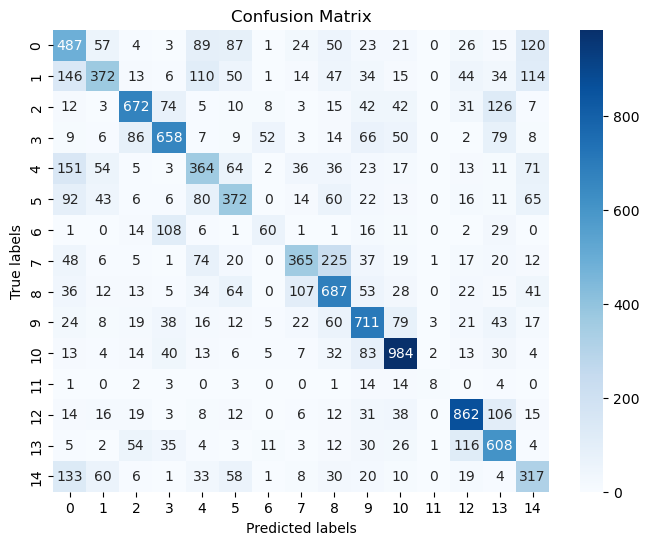

In [19]:
# Assuming you have already trained your model and X_test contains test data
# Get predictions from your trained model
y_pred_labels = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_labels, axis=1)

# Now, you can compute the confusion matrix using y_test and y_pred_classes
confusion = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [21]:
data_1 = np.load('E:\\Research\\test\\data_32_14.npy')
print(data_1.shape)

(65535, 32, 32)


In [22]:
# Create CNN model
import tensorflow as tf
import keras
from keras import datasets, layers, models
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32,32,1)))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(Dropout(0.50))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

#model.add(Dropout(0.50))
model.add(layers.Flatten())
model.add(layers.Dense(1024,  activation='relu'))
#model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(15, activation='softmax'))
# Compile model
#opt = keras.optimizers.Adam(learning_rate=0.0001)

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        36928     
                                                      

In [24]:
model.compile(optimizer='Adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
#model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
#history = model.fit(X_train, y_train, epochs=20, batch_size=256, validation_split=.2)
history = model.fit(X_train, y_train, epochs=20, batch_size=256, validation_data=(X_val,y_val))

Epoch 1/20
154/154 [==============================] - 256s 2s/step - loss: 2.2424 - accuracy: 0.2473 - val_loss: 1.6768 - val_accuracy: 0.4394
Epoch 2/20
154/154 [==============================] - 300s 2s/step - loss: 1.5733 - accuracy: 0.4629 - val_loss: 1.2585 - val_accuracy: 0.5675
Epoch 3/20
154/154 [==============================] - 333s 2s/step - loss: 1.2335 - accuracy: 0.5664 - val_loss: 0.9758 - val_accuracy: 0.6657
Epoch 4/20
154/154 [==============================] - 103s 670ms/step - loss: 1.0224 - accuracy: 0.6391 - val_loss: 0.8474 - val_accuracy: 0.7102
Epoch 5/20
154/154 [==============================] - 99s 643ms/step - loss: 0.9012 - accuracy: 0.6813 - val_loss: 0.7581 - val_accuracy: 0.7379
Epoch 6/20
154/154 [==============================] - 100s 649ms/step - loss: 0.8045 - accuracy: 0.7139 - val_loss: 0.6762 - val_accuracy: 0.7679
Epoch 7/20
154/154 [==============================] - 100s 649ms/step - loss: 0.7274 - accuracy: 0.7440 - val_loss: 0.6327 - val_accur

410/410 - 22s - loss: 0.4172 - accuracy: 0.8600 - 22s/epoch - 55ms/step


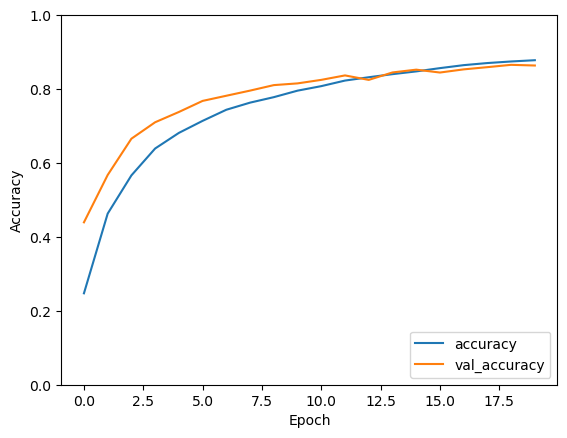

In [25]:
import matplotlib.pyplot as pl
pl.plot(history.history['accuracy'], label='accuracy')
pl.plot(history.history['val_accuracy'], label = 'val_accuracy')
pl.xlabel('Epoch')
pl.ylabel('Accuracy')
pl.ylim([0, 1])
pl.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2) 